In [102]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import math
from pathlib import Path
from typing import Any, Dict, List, Optional

import rasterio
import contextily
import geopandas
import haversine as hs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from tqdm.notebook import tqdm
from PIL import Image

from huhuha.settings import RAW_DATA_DIR, DATA_DIR, PLOTS_DIR
from huhuha.ops_tiles import get_otm_tile
from huhuha.utils import get_elevation, random_float
from huhuha.centered_tiles import get_otm_center_tile

tqdm.pandas()
sns.set_theme(style='whitegrid', context='talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Wczytanie zbioru danych

In [4]:
avalnache_data_path =  RAW_DATA_DIR / 'data-avalanche.csv'
df = pd.read_csv(avalnache_data_path)

In [3]:
with pd.option_context('display.max_columns', None):
    display(df.head())

,id,date,massif,sommet,itineraire,description,orientation,caracteristique,origine_principale,origine_secondaire,type_ecoulement_principal,qualite_neige,risque_meteo_france,latitude,longitude,thumbnail,imagesNb,isPrivate,tags,updated,altitude_depart,altitude_arrivee
0,1642072642225,1641942000000,aiguilles d arves,Aiguille de l'Epaisseur,NaN,"b""Apres s'etre decale trop sur la gauche par r...",E,b'',"Ski touring, uphill",NaN,NaN,NaN,Inconnu,45.130920,6.357383,/attached-files/thumbnails/1642072461149-IMG20...,2,False,NaN,1642074353000,3100,0
1,1642001062328,1641942000000,NaN,NaN,Mont Joly,b'Descente du Pcheu au Mont Joly. \r\nDeclench...,E,b'',NaN,NaN,NaN,NaN,Inconnu,45.825902,6.693000,/attached-files/thumbnails/1642000995871-6792F...,1,False,NaN,1642013122000,2500,1180
2,1642005733893,1641855600000,Haute Maurienne,Pointe de Vallonbrun,NaN,"b""Petite avalanche partie spontanement, probab...",SE,b'Wind slab',NaN,NaN,NaN,NaN,3 - MARQUE,45.317667,6.937318,/attached-files/thumbnails/1642005733893-16420...,2,False,NaN,1642005978000,2630,2240
3,1641931532871,1641855600000,Belledonne,pointe du sciallet,"Sommet du sciallet par l'éperon est, permettan...","b""Declenchement de la plaque par 1 skieur. \r\...",E,b'',"Ski touring, downhill",NaN,NaN,NaN,Inconnu,45.212236,6.013909,/attached-files/thumbnails/1641931326001-inbou...,3,False,NaN,1641931532000,2300,2200
4,1641918131562,1641855600000,Mont Thabor,Roche de la Pelle,NaN,"b""Avalanche spontanee partie tres probablement...",NE,b'Soft slab',NaN,NaN,Aerosol,NaN,3 - MARQUE,45.136030,6.551387,/attached-files/thumbnails/1641918131562-16419...,5,False,NaN,1641918700000,2820,2450


Przeformatowanie daty, usnięcie błędnych wspołrzednych

In [7]:
df = df.drop(df[(df.latitude == 0.0) | (df.longitude == 0.0)].index)
df['date_formated'] = df.date.apply(lambda d: pd.to_datetime(d, unit='ms'))
df['date_updated_formated'] = df.updated.apply(lambda d: pd.to_datetime(d, unit='ms'))

In [8]:
df

,id,date,massif,sommet,itineraire,description,orientation,caracteristique,origine_principale,origine_secondaire,...,longitude,thumbnail,imagesNb,isPrivate,tags,updated,altitude_depart,altitude_arrivee,date_formated,date_updated_formated
0,1642072642225,1641942000000,aiguilles d arves,Aiguille de l'Epaisseur,NaN,"b""Apres s'etre decale trop sur la gauche par r...",E,b'',"Ski touring, uphill",NaN,...,6.357383,/attached-files/thumbnails/1642072461149-IMG20...,2,False,NaN,1642074353000,3100,0,2022-01-11 23:00:00,2022-01-13 11:45:53
1,1642001062328,1641942000000,NaN,NaN,Mont Joly,b'Descente du Pcheu au Mont Joly. \r\nDeclench...,E,b'',NaN,NaN,...,6.693000,/attached-files/thumbnails/1642000995871-6792F...,1,False,NaN,1642013122000,2500,1180,2022-01-11 23:00:00,2022-01-12 18:45:22
2,1642005733893,1641855600000,Haute Maurienne,Pointe de Vallonbrun,NaN,"b""Petite avalanche partie spontanement, probab...",SE,b'Wind slab',NaN,NaN,...,6.937318,/attached-files/thumbnails/1642005733893-16420...,2,False,NaN,1642005978000,2630,2240,2022-01-10 23:00:00,2022-01-12 16:46:18
3,1641931532871,1641855600000,Belledonne,pointe du sciallet,"Sommet du sciallet par l'éperon est, permettan...","b""Declenchement de la plaque par 1 skieur. \r\...",E,b'',"Ski touring, downhill",NaN,...,6.013909,/attached-files/thumbnails/1641931326001-inbou...,3,False,NaN,1641931532000,2300,2200,2022-01-10 23:00:00,2022-01-11 20:05:32
4,1641918131562,1641855600000,Mont Thabor,Roche de la Pelle,NaN,"b""Avalanche spontanee partie tres probablement...",NE,b'Soft slab',NaN,NaN,...,6.551387,/attached-files/thumbnails/1641918131562-16419...,5,False,NaN,1641918700000,2820,2450,2022-01-10 23:00:00,2022-01-11 16:31:40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3912,1415356829764,38444400000,Maurienne,Rateau d'Aussois,RD 215-Sainte Apolonie,NaN,S,b'',Unknown,NaN,...,6.702358,NaN,0,True,NaN,1415358302000,0,1100,1971-03-21 23:00:00,2014-11-07 11:05:02
3913,50000215,4662000000,Haute Maurienne,Grand Roc Noir,Couloir du Pichet. RD 902,NaN,S,b'',Snow,Wind,...,6.891223,NaN,0,True,NaN,1453970425000,0,1470,1970-02-23 23:00:00,2016-01-28 08:40:25
3935,1551114492230,-280976400000,Maurienne,Modane - La Freney,Roche Fleurie,NaN,N,b'',NaN,NaN,...,6.609403,NaN,0,True,NaN,1551115398000,2450,980,1961-02-04 23:00:00,2019-02-25 17:23:18
3948,1417037422856,-881028000000,Maurienne,Saint Colomban des Villards,RD 927 Combe Barral,NaN,NE,b'',NaN,NaN,...,6.226351,NaN,0,True,"RTM,",1417037668000,0,1100,1942-01-30 22:00:00,2014-11-26 21:34:28


In [17]:
# with pd.option_context('display.max_rows', 100):
#     display(df.sort_values(by="date_formated").head(100))

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3457 entries, 0 to 3949
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   id                         3457 non-null   int64         
 1   date                       3457 non-null   int64         
 2   massif                     3369 non-null   object        
 3   sommet                     2987 non-null   object        
 4   itineraire                 2558 non-null   object        
 5   description                2623 non-null   object        
 6   orientation                3457 non-null   object        
 7   caracteristique            3457 non-null   object        
 8   origine_principale         2552 non-null   object        
 9   origine_secondaire         435 non-null    object        
 10  type_ecoulement_principal  263 non-null    object        
 11  qualite_neige              1006 non-null   object        
 12  risque

In [19]:
df['year'] = df["date_formated"].apply(lambda d: d.year)

In [36]:
ax.patches[0].get_x()

0

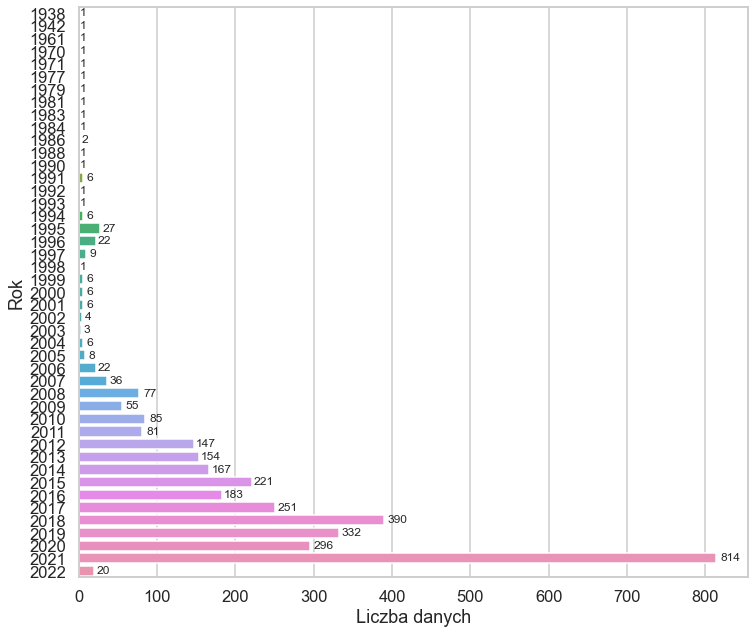

In [49]:
fig, ax = plt.subplots(figsize=(12, 10.5))
sns.countplot(y=df['year'], ax=ax)

y_offset = 0.2
for p in ax.patches:
    _x = p.get_x() + p.get_width()
    _y = p.get_y() + p.get_height()/2 + y_offset
    value = p.get_width()
    x_offset = 5 + math.log(value) * 2
    _x += x_offset
    ax.text(_x, _y, value, ha="center", fontsize=12) 


ax.set_ylabel('Rok')
ax.set_xlabel('Liczba danych')
fig.savefig(PLOTS_DIR / 'year_data_count.png', dpi=400, bbox_inches='tight', transparent=True)

In [50]:
columns_to_keep = ['id', 'date', 'updated', 'massif', 'sommet', 'description', 'orientation', 'latitude', 'longitude']
df = df[columns_to_keep]

Utworzenie `GeoDataFrame` z padnasowego df-a.

In [51]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))

In [52]:
gdf.head(2)

,id,date,updated,massif,sommet,description,orientation,latitude,longitude,geometry
0,1642072642225,1641942000000,1642074353000,aiguilles d arves,Aiguille de l'Epaisseur,"b""Apres s'etre decale trop sur la gauche par r...",E,45.130920,6.357383,POINT (6.35738 45.13092)
1,1642001062328,1641942000000,1642013122000,NaN,NaN,b'Descente du Pcheu au Mont Joly. \r\nDeclench...,E,45.825902,6.693000,POINT (6.69300 45.82590)


## Naniesienie punktów na mapę

Cały świat

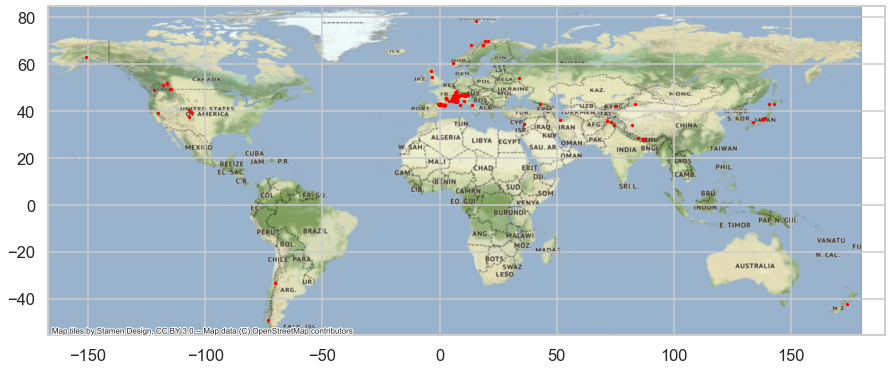

In [63]:
ax = gdf.plot(markersize=3, figsize=(15, 10), color='red')
contextily.add_basemap(ax, crs=gdf.crs.to_string())
plt.savefig(PLOTS_DIR / 'world_avalanches.png', dpi=400, bbox_inches='tight')

Europa

In [11]:
gdf_europe = gdf[(gdf.latitude > 15) & (gdf.latitude < 70.0) & (gdf.longitude > - 15.0) & (gdf.longitude < 40.0)]

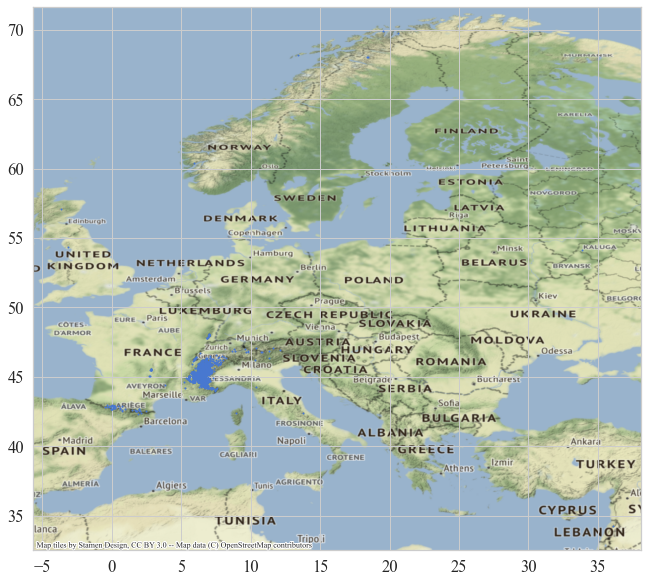

In [12]:
ax = gdf_europe.plot(markersize=1,figsize=(12, 10))
contextily.add_basemap(ax, crs=gdf_europe.crs.to_string())

Alpy -- rejon Francji

In [64]:
ALPS_LAT_LOWER = 44
ALPS_LAT_UPPER = 47.5
ALPS_LONG_LOWER = 5
ALPS_LONG_UPPER = 8.5

gdf_french_alps = gdf[(gdf.latitude > ALPS_LAT_LOWER) & (gdf.latitude < ALPS_LAT_UPPER) & 
                      (gdf.longitude > ALPS_LONG_LOWER) & (gdf.longitude < ALPS_LONG_UPPER)]

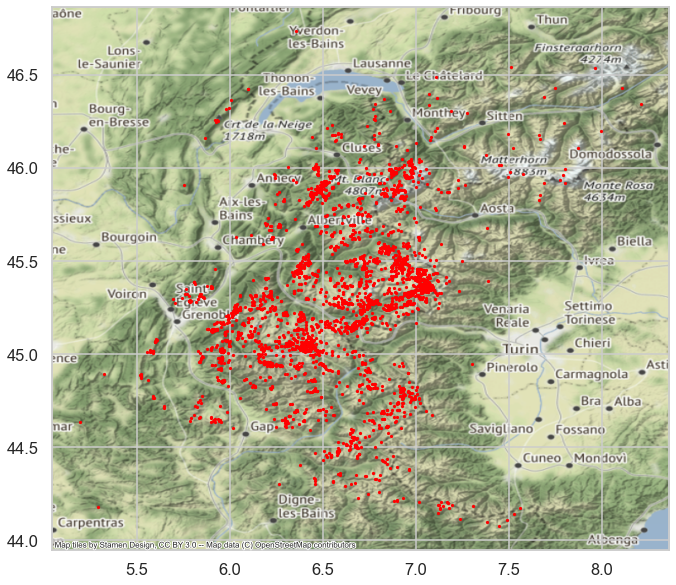

In [65]:
ax = gdf_french_alps.plot(markersize=3, color='red', figsize=(12, 10))
contextily.add_basemap(ax, crs=gdf_french_alps.crs.to_string())
plt.savefig(PLOTS_DIR / 'alps_avalanches.png', dpi=400, bbox_inches='tight')

## Odczyt pliku

In [67]:
df = pd.read_csv(DATA_DIR / 'avalanches-dataset.csv')

In [68]:
gdf = geopandas.GeoDataFrame(
    df, geometry=geopandas.points_from_xy(df.longitude, df.latitude, crs="EPSG:4326"))

In [70]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7293 entries, 0 to 7292
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   id                     7293 non-null   object  
 1   date                   3297 non-null   float64 
 2   updated                3297 non-null   float64 
 3   massif                 3213 non-null   object  
 4   sommet                 2856 non-null   object  
 5   description            2471 non-null   object  
 6   orientation            3297 non-null   object  
 7   latitude               7293 non-null   float64 
 8   longitude              7293 non-null   float64 
 9   tile_filename_zoom_16  7293 non-null   object  
 10  Avalanche              7293 non-null   int64   
 11  elevations             7293 non-null   float64 
 12  geometry               7293 non-null   geometry
dtypes: float64(5), geometry(1), int64(1), object(6)
memory usage: 740.8+ KB


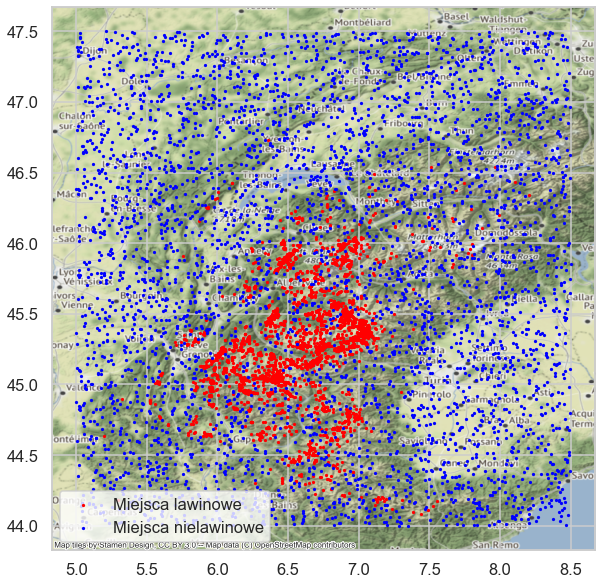

In [94]:
fig, ax = plt.subplots(figsize=(12,10))
gdf[gdf.Avalanche == 1].plot(markersize=3, legend=True, ax=ax, color='red', label='Miejsca lawinowe')
gdf[gdf.Avalanche == 0].plot(markersize=3, legend=True, ax=ax, color='blue', label='Miejsca nielawinowe')
ax.legend()
contextily.add_basemap(ax, crs=gdf.crs.to_string())
plt.savefig(PLOTS_DIR / 'pos_neg_avalanches.png', dpi=400, bbox_inches='tight', transparent=True)

<AxesSubplot:title={'center':'Avalanches count'}>

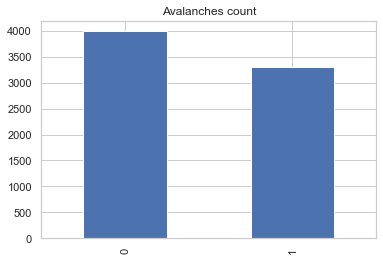

In [11]:
df['Avalanche'].value_counts().plot(kind='bar', title='Avalanches count')

# Tilesy

In [104]:
lat = 49.179306
lon = 20.088444

z = 14

folder=f'{DATA_DIR}/rysy_center_tiles/'

try:
    _ct = get_otm_center_tile(lat, lon, zoom=z, source='opentopomap')
    _ca = get_otm_center_tile(lat, lon, zoom=z, source='arcgis')

    im_ct = Image.fromarray(_ct)
    im_ca = Image.fromarray(_ca)

    ca_folder_path = f'{folder}/arcgis/{z}' 
    ct_folder_path = f'{folder}/opentopomap/{z}'

    Path.mkdir(Path(ca_folder_path), parents=True, exist_ok=True)
    Path.mkdir(Path(ct_folder_path), parents=True, exist_ok=True)

    im_ca.save(f'{ca_folder_path}/rysy.png')
    im_ct.save(f'{ct_folder_path}/rysy.png')

except Exception as e:
    print(e)
